# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [2]:
# import needed python libraries

#%pip install -r requirements.txt

import numpy as np 
import pandas as pd 
import seaborn as sns 
import random
import matplotlib.pyplot as plt 
from matplotlib.ticker import StrMethodFormatter

from imblearn.pipeline import Pipeline

import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly
from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix,  mean_squared_error, mean_absolute_error, accuracy_score, RocCurveDisplay, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from art.estimators.classification import KerasClassifier # type: ignore
from art.attacks.evasion import FastGradientMethod # type: ignore
from collections import Counter # To do counter of some features

import torch # type: ignore
from torch import nn
import torch.nn.functional as F

from imblearn.over_sampling import SMOTE # type: ignore
from imblearn.under_sampling import RandomUnderSampler # type: ignore

#### this code, allow us to work with offline plotly version
py.init_notebook_mode(connected=True) 

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
import warnings
warnings.filterwarnings('ignore')

d:\WINDOWS\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

---
Begin by downloading the [German Credit Risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In [3]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)
df

,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good_bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### We create a hard copy To use in the visualization part.

In [ ]:
df_credit = df.copy()

As we can see the value used for describing the response are $1 \implies good$ result and $2 \implies bad$ result. 

With df.info() we can find if some data are missing

### 1.2 Data Preprocessing ###

---
As a preprocessing step, convert categorical features to numerical features, e.g., by means of a one-hot
encoding, and apply a normalization to map all features between [0,1]. Assign labels to the dataset
indicating the true loan attribution outcomes for supervised learning. Clearly define categories or
classes representing loan approval or denial. Additionally, reserve 20% of the dataset for final testing
and assessment of the robustness of the models.

In [3]:
#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
# display(df_encoded)

#### Setting bad to 0 and good to 1
mask_bad = df_encoded['good_bad'] == 2
df_encoded["good_bad"] = np.where(mask_bad, 0, 1)

#### Normalization between [0,1]
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
array_df_encoded = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded, columns=df_encoded.columns)
df_normalized_no_label = df_normalized.drop(columns="good_bad")
display(df_normalized)
display(df_normalized_no_label)

,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good_bad,Status_account_A11,Status_account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,Status_account_A11,Status_account_A12,Status_account_A13,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### From this moment on for our work we use as a  reference $1 \implies good$ and $0 \implies bad$. 

# 2 Unsupervised exploration and clustering #

### 2.1 Dimensionality reduction for data visualization ###

In [ ]:
#### Splitting the data into sets 
columns_no_label = df_normalized_no_label.columns
# X, X_test, y, y_test = train_test_split(
#     df_normalized_no_label[columns_no_label], # X
#     df_normalized['good_bad'], # y
#     stratify = df_normalized['good_bad'], # stratify the dataset based on class labels
#     train_size = 0.8, # percentage of training set
#     random_state = 15 
# )

<function matplotlib.pyplot.show(close=None, block=None)>

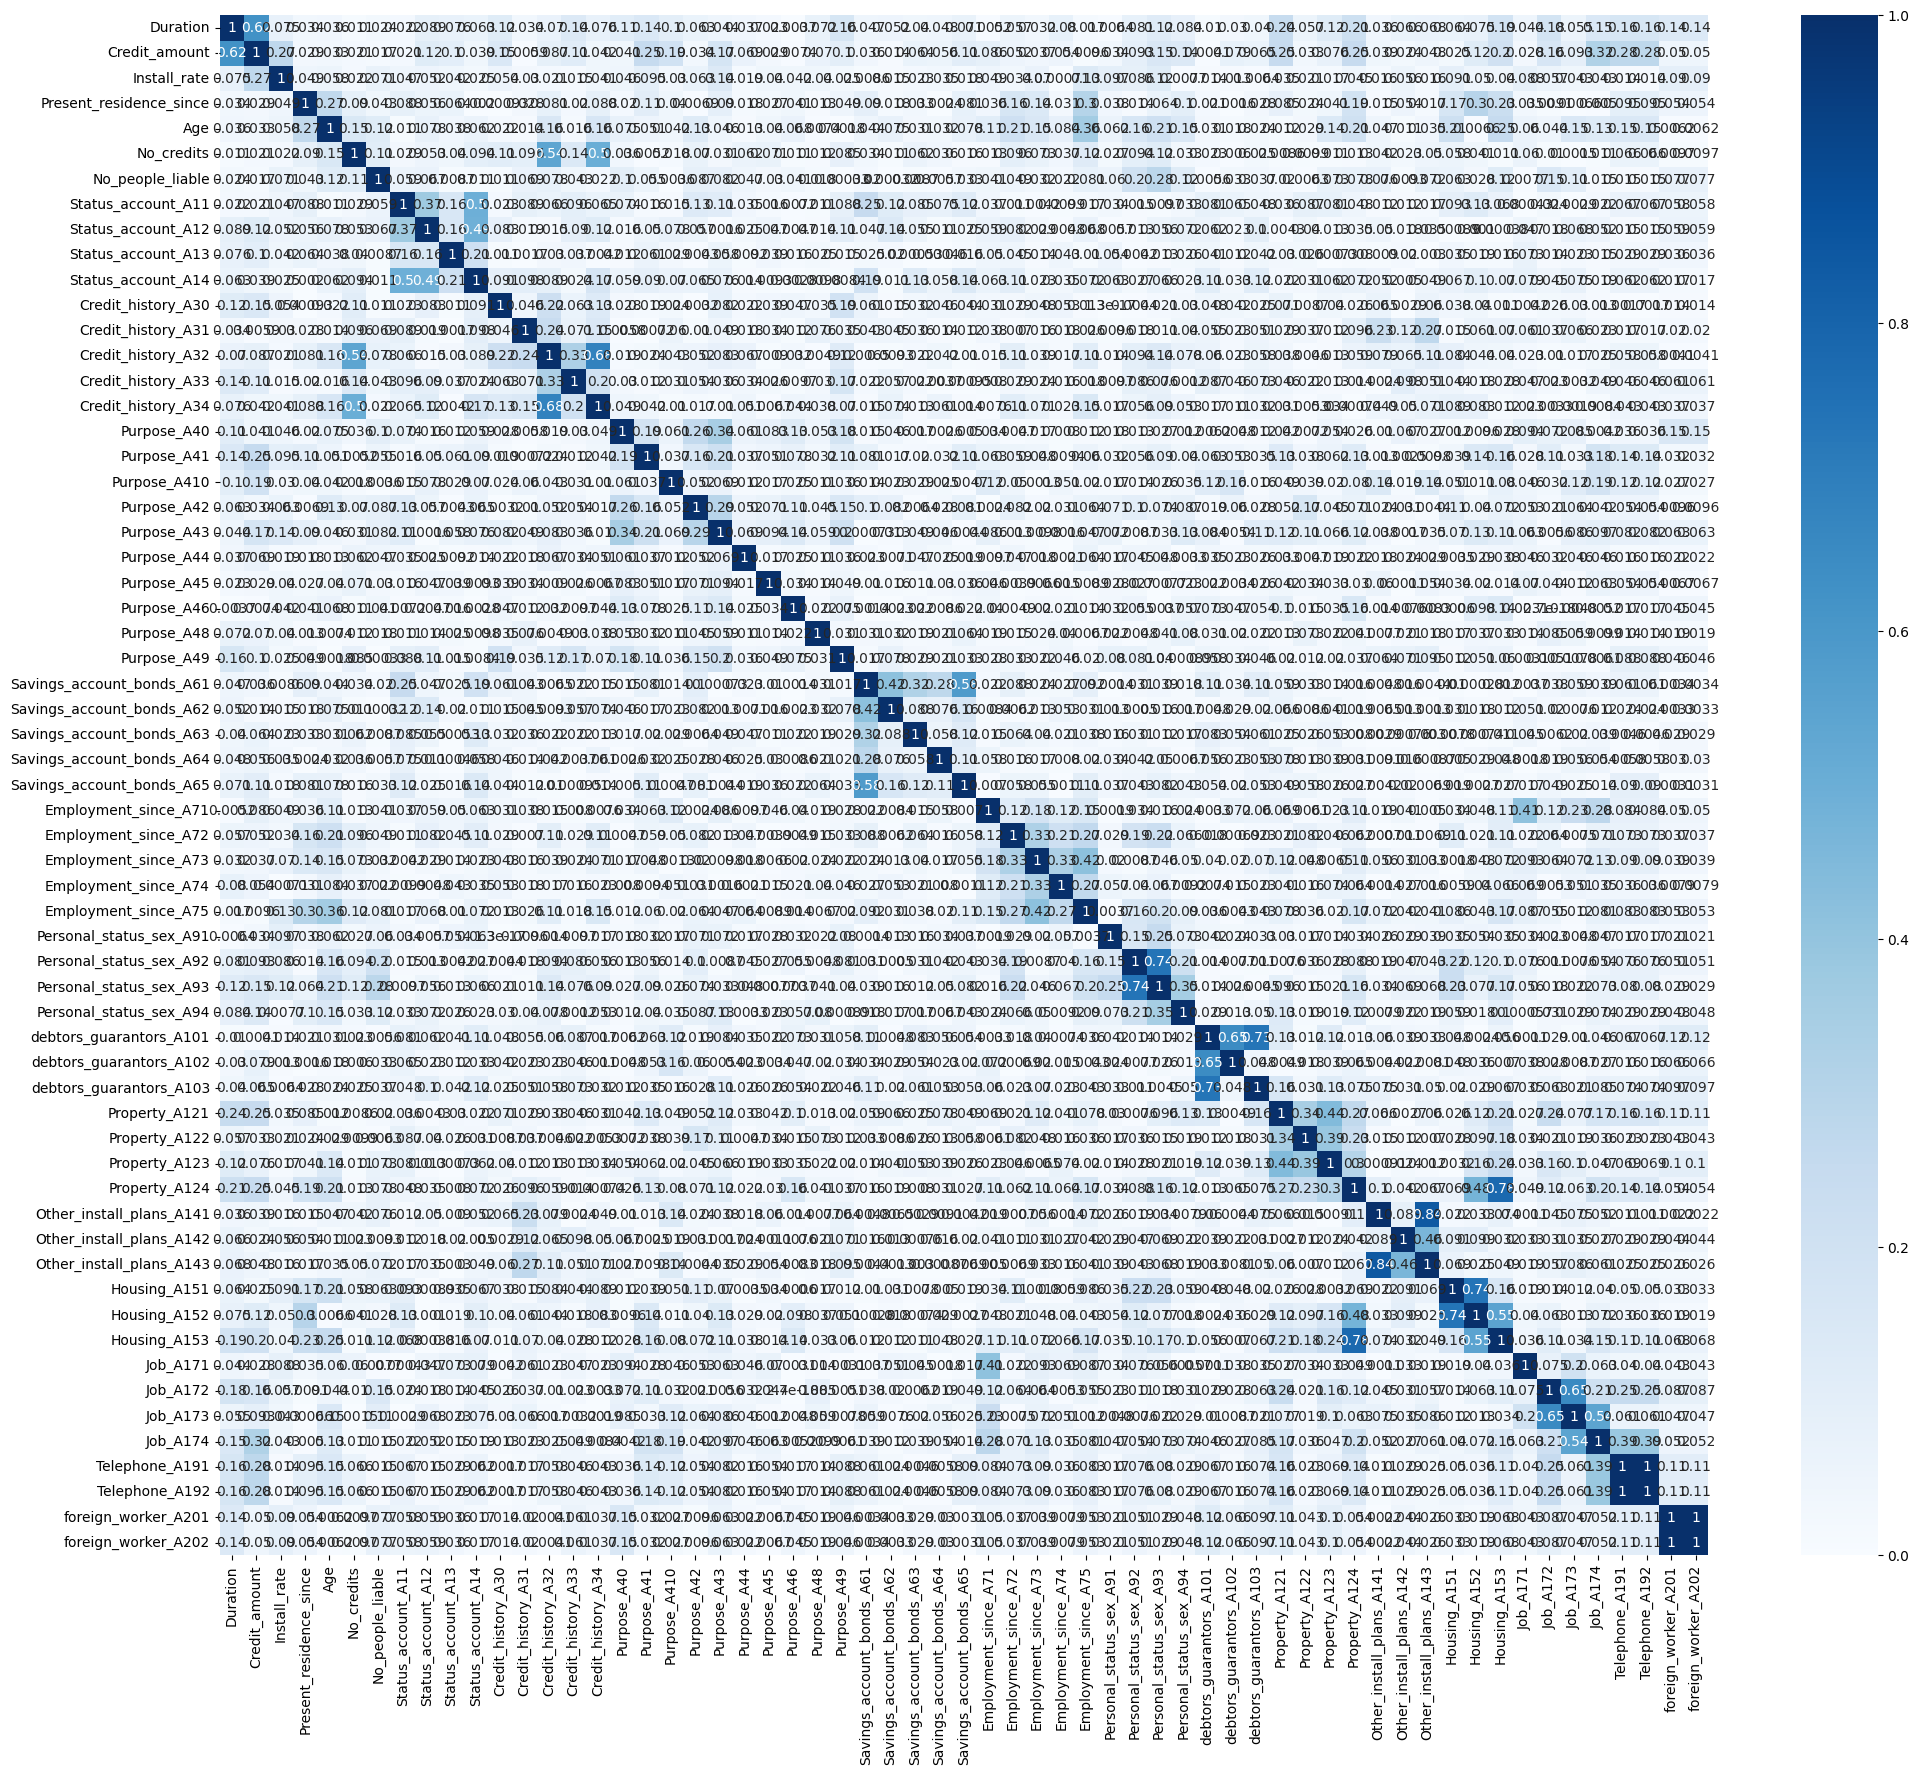

In [5]:
#### Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
#### and Principal Component Analysis (PCA) to reduce and visualize the data.

#### I compute the correlation between the features to see if there are any correlated features
correlation_analysis = df_normalized_no_label[df_normalized_no_label.columns].corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

##### 2.1.1 PCA

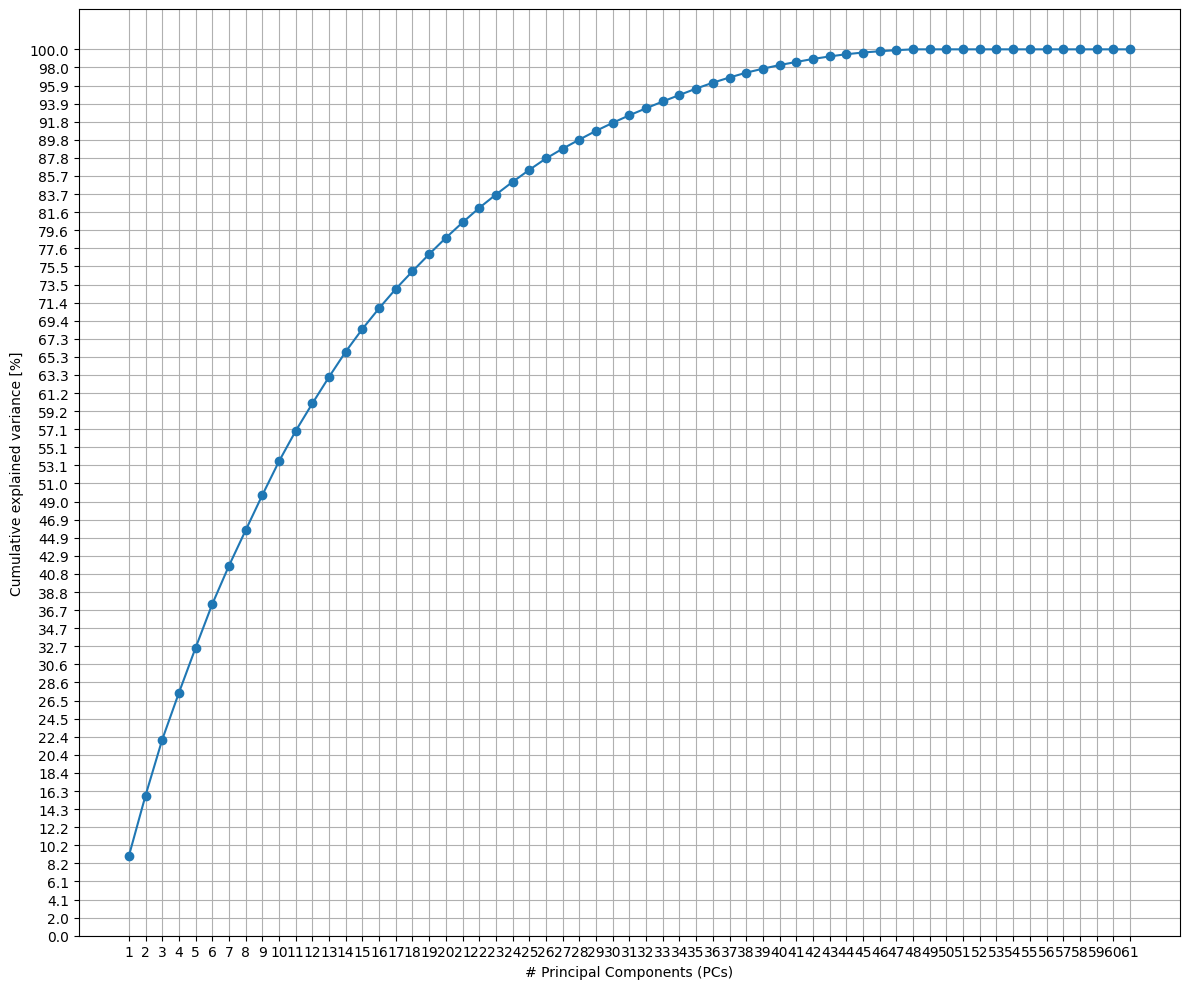

0 : 8.977101843701538
1 : 15.816006080223818
2 : 22.11908947884602
3 : 27.395886158707278
4 : 32.47790632722247
5 : 37.41054036706566
6 : 41.7353597639989
7 : 45.736331964404734
8 : 49.70856577537145
9 : 53.519904896044515
10 : 56.94917219085873
11 : 60.04953232377629
12 : 63.04491071913437
13 : 65.89897227452045
14 : 68.46048081993972
15 : 70.79147541813832
16 : 72.9726716937579
17 : 74.96343626360961
18 : 76.89143825298001
19 : 78.73318153677663
20 : 80.4676531950549
21 : 82.11365297084275
22 : 83.61339370807887
23 : 85.0468767359495
24 : 86.40115857253107
25 : 87.68698913988977
26 : 88.78979397775494
27 : 89.8181617812929
28 : 90.80357897961515
29 : 91.70751950098793
30 : 92.56259748403582
31 : 93.34972935531562
32 : 94.11705716062797
33 : 94.85073248739575
34 : 95.56995285971207
35 : 96.23631556684367
36 : 96.82238480083879
37 : 97.368230407296
38 : 97.81391117503078
39 : 98.22695218777653
40 : 98.57603917963249
41 : 98.91366767943992
42 : 99.2002711688952
43 : 99.44941588723246
44

In [6]:
#### PCA to check the variances

pca = PCA(random_state=15)
pca.fit(df_normalized_no_label[df_normalized_no_label.columns])

#### Here i compute the variability of the dataset, while the varaible number keeps increasing, 
#### until reaching all the number
explained_variance = pca.explained_variance_ratio_

#### This allows to represent the sum for each step (remember 61 features)
cum_exp_var = np.cumsum(explained_variance)

#### Representing it in percentage
perc_cum_exp_var = cum_exp_var * 100

#### Make the plot of cumulative explained variance w.r.t. number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

for i in range (len(perc_cum_exp_var)):
    print(i, ":", perc_cum_exp_var[i])

##### SMOTE for oversampling

In [7]:
sm = SMOTE(random_state=60)
X_res, y_res = sm.fit_resample(df_normalized_no_label[df_normalized_no_label.columns], df_normalized["good_bad"])
print(len(df_normalized_no_label[df_normalized_no_label.columns]))
print(len(X_res))


unique, counts = np.unique(y_res, return_counts=True)
print(f"the label are distributed in this way: {unique} [0=bad 1=good] = {counts}")
#test
over = SMOTE(random_state=60)
under = RandomUnderSampler(sampling_strategy=0.5)

#steps = [('u', under), ('o', over)]
#pipeline = Pipeline(steps=steps)

# X_res2, y_res2 = under.fit_resample(X, y)
# X_res2, y_res2 = over.fit_resample(X_res2, y_res2)

# unique, counts = np.unique(y_res2, return_counts=True)


# print(f"the label are distributed in this way: {unique} [0=bad 1=good] = {counts}")


1000
1400
the label are distributed in this way: [0. 1.] [0=bad 1=good] = [700 700]


In [9]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 30)
pca.fit(X_res)

X_PCA = pca.transform(X_res)
#X_test_PCA = pca.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

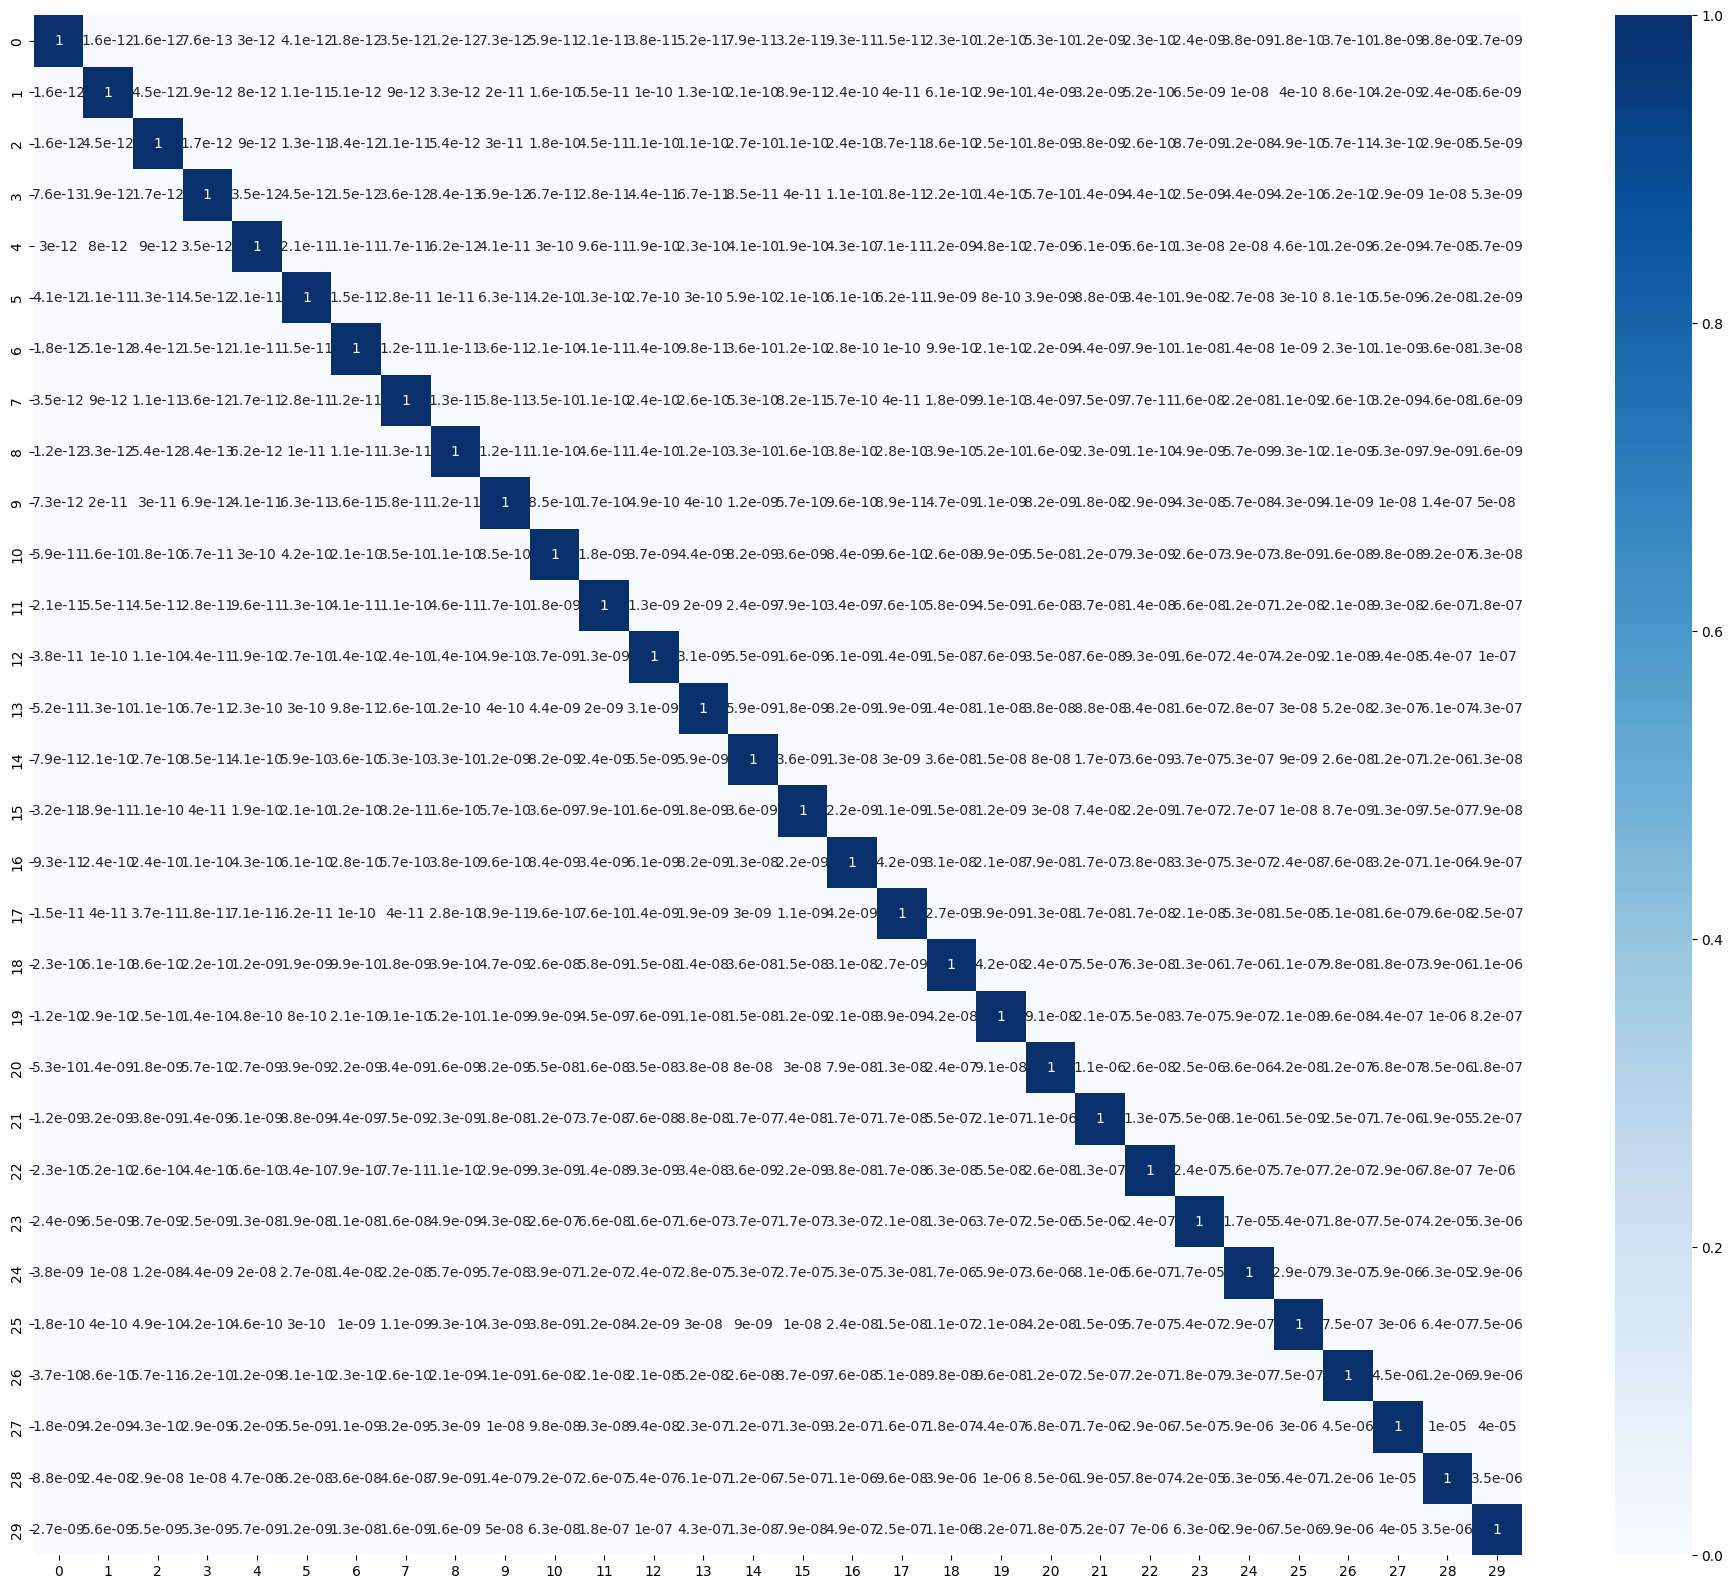

In [10]:
####Compute the correlation matrix after PCA
correlation_analysis = pd.DataFrame(X_PCA).corr().abs()
plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#### No more correlation between different features after PCA
#### X is the transformed training dataset using PCA, it will have 45 features, 
#### with a total variance of the dataset of 99,78%

#     3 Supervised Data Analysis

### 3.1 Classifier Selection
We choose from various classifiers, notably:
- Decision Tree classifier
- Gaussian Naive Bayes classifier
- K-Nearest Neighbors classifier
- Support Vector Machines classifier
- Logistic regressor
- Neural Networks 

### 3.2 Cross-Validation

#### Here we first split the dataset into train and validation sets

In [12]:
print(f"X is: {len(X_res)}")
print(f"y is: {len(y_res)}")

X_train, X_val, y_train, y_val = train_test_split(
    X_PCA, y_res, 
    stratify=y_res, 
    train_size=0.8, 
    random_state=35
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, 
    stratify=y_val, 
    train_size=0.8, 
    random_state=35
)

print(f"X_train is: {len(X_train)}")
print(f"y_train is: {len(y_train)}")
print(f"X_val is: {len(X_val)}")
print(f"y_val is: {len(y_val)}")
print(f"X_test is: {len(X_test)}")
print(f"y_test is: {len(y_test)}")

#### transform numpy array to pytorch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float)
print(X_train_t.shape)
y_train_t = torch.tensor(np.ravel(y_train), dtype=torch.long)
print(y_train_t.shape)
X_val_t = torch.tensor(X_val, dtype=torch.float)
print(X_val_t.shape)
y_val_t = torch.tensor(np.ravel(y_val), dtype=torch.long)
print(y_val_t.shape)
X_test_t = torch.tensor(X_test, dtype=torch.float)
print(X_test_t.shape)
y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)
print(y_test_t.shape)

X is: 1400
y is: 1400
X_train is: 1120
y_train is: 1120
X_val is: 224
y_val is: 224
X_test is: 56
y_test is: 56
torch.Size([1120, 30])
torch.Size([1120])
torch.Size([224, 30])
torch.Size([224])
torch.Size([56, 30])
torch.Size([56])


#### Definition of Neural Network model

In [13]:
class Model_classification_multi(nn.Module): 

    def __init__(self, in_features, out_features, hidden_1, hidden_2, hidden_3,hidden_4, act):
        super().__init__()

        # another way to define the architecture of neural network
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_1),
            act,
            nn.Linear(in_features=hidden_1, out_features=hidden_2),
            act,
            nn.Linear(in_features=hidden_2, out_features=hidden_3),
            act,
            nn.Linear(in_features=hidden_3, out_features=hidden_4),
            act,
            nn.Linear(in_features=hidden_4, out_features=out_features), 
        )

    #### define feedforward process
    def forward(self, x):
        out = F.sigmoid(self.layers(x))
        return out

#### define the loss function
loss_fn = nn.CrossEntropyLoss()

#### define the accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

#### Grid search for Neural Network model

In [14]:
#defining the parameters for the grid search
n_possible_act = [nn.ReLU()]
#n_possible_nodes = [63,163,1063]
n_possible_nodes = [1063]
#n_possible_lr = [ 1e-2,1e-4,1e-6 ]
n_possible_lr = [ 1e-1 ]
epochs = 1100
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}
possible_seeds = []

for i in range(5):
    random.seed()
    possible_seeds.append(random.randrange(-9223372036854775808, 18446744073709551615,1))

lock_acc_val = 0
for act in n_possible_act:
    for n_nodes in n_possible_nodes:
        for lr in n_possible_lr:
            for seed in possible_seeds:
                previous = 0
                epoch = 0
                # set a random seed 
                torch.manual_seed(seed)

                # initialize the model with the correspoding parameters
                model = Model_classification_multi(
                    in_features = X_train_t.shape[-1], 
                    out_features = np.unique(y_train).shape[0], 
                    hidden_1 = n_nodes, 
                    hidden_2 = n_nodes,
                    hidden_3 = n_nodes,
                    hidden_4 = n_nodes,
                    act=act
                )
                #print(X_train_t.shape[-1])
                # define the optimizer (pass the parameters (model) that you want to optimize, and the learning rate)
                #optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

                print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} seed={seed} ****")

                while epoch < 1100:

                    if epoch == 1:
                        print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')

                    # model training phase
                    model.train()
                    y_prob = model(X_train_t).squeeze() # get the output probability of predictions
                    loss = loss_fn(y_prob, y_train_t) # calculate the loss
                    optimizer.zero_grad() # reset the gradients of model parameters
                    loss.backward() # backpropagate the prediction loss
                    optimizer.step() # adjust the parameters by the gradients 

                    # model evaluation phase
                    model.eval()

                    # training set
                    y_prob = model(X_train_t).squeeze()
                    y_pred = torch.argmax(y_prob, dim=-1) # get the label
                    acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

                    # validation set
                    y_prob = model(X_val_t).squeeze()
                    loss_val = loss_fn(y_prob, y_val_t) 
                    y_pred = torch.argmax(y_prob, dim=-1) 
                    acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

                    # test set
                    y_prob = model(X_test_t).squeeze()
                    loss_test = loss_fn(y_prob, y_test_t) 
                    y_pred = torch.argmax(y_prob, dim=-1) 
                    acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
                    
                    if(acc_val >= 0.9):
                        torch.save(model.state_dict(), "./CreditModel.model")
                        break

                    if(epoch%30 == 0):
                        if(epoch > 50 and acc_val == previous):
                            print(f"lock acc_val = {acc_val}")
                            if(lock_acc_val <= acc_val):
                                torch.save(model.state_dict(), "./stoppedCreditModel.model")
                            epoch = 1100
                            lock_acc_val = acc_val
                        previous = acc_val
                        
                    if(acc_val > best_acc):
                        best_acc = acc_val
                        best_mode["act"] = act
                        best_mode["n_nodes"] = n_nodes
                        best_mode["lr"] = lr
                        torch.save(model.state_dict(), "./CreditModel.model")
                        
                    epoch = epoch+1
                    if (epoch%49 == 0): 
                        PATH = "model.pt"

                        torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'loss': loss,
                                    }, PATH)
                        print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
print(f'Best Combination of Parameters : Activation Function={best_mode["act"]}, Number of Nodes={best_mode["n_nodes"]}, Learning Rate={best_mode["lr"]}')
print(f'Best Validation Accuracy = {best_acc}')


***** Test with lr=0.1, n_nodes=1063, act=ReLU() seed=-8755909960046184722 ****

Epoch: 1 |
 Train Loss: 0.69330, Val Loss: 0.69334, Test Loss: 0.69327,
 Train Acc: 0.45, Val Acc: 0.45, Test Acc: 0.48

Epoch: 49 |
 Train Loss: 0.67610, Val Loss: 0.67329, Test Loss: 0.67252,
 Train Acc: 0.72, Val Acc: 0.73, Test Acc: 0.73
lock acc_val = 0.7678571428571429

***** Test with lr=0.1, n_nodes=1063, act=ReLU() seed=2352766885825176 ****

Epoch: 1 |
 Train Loss: 0.69302, Val Loss: 0.69312, Test Loss: 0.69307,
 Train Acc: 0.50, Val Acc: 0.50, Test Acc: 0.50

Epoch: 49 |
 Train Loss: 0.67231, Val Loss: 0.66951, Test Loss: 0.66988,
 Train Acc: 0.75, Val Acc: 0.75, Test Acc: 0.73

Epoch: 98 |
 Train Loss: 0.50133, Val Loss: 0.53816, Test Loss: 0.52859,
 Train Acc: 0.81, Val Acc: 0.78, Test Acc: 0.82

Epoch: 147 |
 Train Loss: 0.39292, Val Loss: 0.51333, Test Loss: 0.51481,
 Train Acc: 0.93, Val Acc: 0.79, Test Acc: 0.82

Epoch: 196 |
 Train Loss: 0.36739, Val Loss: 0.51272, Test Loss: 0.49202,
 T

### 3.3 Classifier Evaluation

#### Neural Network resume


In [ ]:
#defining the parameters for the grid search
n_possible_act = [nn.ReLU()]
n_possible_nodes = [1063]
n_possible_lr = [ 1e-1 ]
epochs = 1100
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}
possible_seeds = []

for i in range(100):
    random.seed()
    possible_seeds.append(random.randrange(-9223372036854775808, 18446744073709551615,1))


# initialize the model with the correspoding parameters
model = Model_classification_multi(
    in_features = X_train_t.shape[-1], 
    out_features = np.unique(y_train).shape[0], 
    hidden_1 = n_nodes, 
    hidden_2 = n_nodes,
    hidden_3 = n_nodes,
    hidden_4 = n_nodes,
    act=act
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
checkpoint = torch.load("./model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
previous = 0

for seed in possible_seeds:

    print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} ****")

    while epoch < 1100:
        
        # model training phase
        model.train()
        y_prob = model(X_train_t).squeeze() # get the output probability of predictions
        loss = loss_fn(y_prob, y_train_t) # calculate the loss
        optimizer.zero_grad() # reset the gradients of model parameters
        loss.backward() # backpropagate the prediction loss
        optimizer.step() # adjust the parameters by the gradients 

        # model evaluation phase
        model.eval()

        # training set
        y_prob = model(X_train_t).squeeze()
        y_pred = torch.argmax(y_prob, dim=-1) # get the label
        acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

        # validation set
        y_prob = model(X_val_t).squeeze()
        loss_val = loss_fn(y_prob, y_val_t) 
        y_pred = torch.argmax(y_prob, dim=-1) 
        acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

        # test set
        y_prob = model(X_test_t).squeeze()
        loss_test = loss_fn(y_prob, y_test_t) 
        y_pred = torch.argmax(y_prob, dim=-1) 
        acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
        
        if(acc_val >= 0.9):
            torch.save(model.state_dict(), "./CreditModel.model")
            break
        
        if (epoch%49 == 0): 
            print(previous)
        
        if(epoch > 50 and acc_val == previous):
            torch.save(model.state_dict(), "./CreditModel.model")
            epoch = 1100
        
        previous = acc_val
        if(acc_val > best_acc):
            best_acc = acc_val
            best_mode["act"] = act
            best_mode["n_nodes"] = n_nodes
            best_mode["lr"] = lr
            torch.save(model.state_dict(), "./CreditModel.model")
            

        if (epoch%50 == 0): 
            print(acc_val)
            PATH = "model.pt"

            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        }, PATH)
            print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
print(f'Best Combination of Parameters : Activation Function={best_mode["act"]}, Number of Nodes={best_mode["n_nodes"]}, Learning Rate={best_mode["lr"]}')
print(f'Best Validation Accuracy = {best_acc}')

In [1]:
#### Validation set
model.load_state_dict(torch.load("./CreditModel.model"))
model.eval()
y_prob = model(X_val_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)
print(f'\nThe accuracy of validation set is: {acc_val:.3f}')
print(classification_report(y_val_t, y_pred))
confusion = confusion_matrix(y_val_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

NameError: name 'model' is not defined


The accuracy of test set is: 0.804
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.79      0.82      0.81        28

    accuracy                           0.80        56
   macro avg       0.80      0.80      0.80        56
weighted avg       0.80      0.80      0.80        56



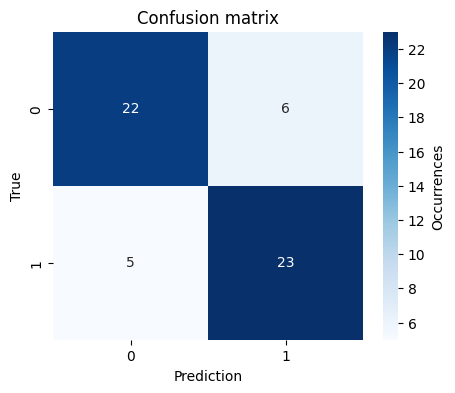

the true label are distributed in this way: [0 1] [0=bad 1=good] = [28 28]


In [19]:
#### Test set
model.eval()
y_prob = model(X_test_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
print(f'\nThe accuracy of test set is: {acc_test:.3f}')
print(classification_report(y_test_t, y_pred))
confusion = confusion_matrix(y_test_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

unique, counts = np.unique(y_test_t.detach().numpy(), return_counts=True)
print(f"the true label are distributed in this way: {unique} [0=bad 1=good] = {counts}")